In [2]:
# Numerical analysis module
import numpy as np
# Plot module
import matplotlib.pyplot as plt
import pandas as pd
# read netCDF files
import xarray as xr
import datetime
import openpyxl

To Do list Données: 
-Mettre les paramètres dans un dictionnaire 
-Créer la fonction calcul de cout 


# Paramètres de l'optimisation

#### Capacité de production

In [17]:
#Generator 
solar_gen = 20  #MW
wind_gen = 20  #Mw
diesel_gen = 20 #Mw

#Storage 
charging_power = 5  #MW
Energy = 10 ##MWh
#Aleady installed Diesel 
diesel_param =16

capacity_data = {'solar_gen':solar_gen,'wind_gen':wind_gen,'diesel_gen':diesel_gen,'charging_power':charging_power,'Energy':Energy,'diesel_param':diesel_param}

#### Paramètres de cout

In [20]:
#Variable Cost
unserved_energy_cost= 10000 #€/Mwh 
diesel_variable_cost = 50 #€/Mwh

# Initial Cost of new capacity 
solar_cost = 1e6  #€/Mw
wind_cost = 1e6  #€/Mw
diesel_cost = 1e6  #€/Mw
storage_power_cost = 200000   #€/Mw
storage_energy_cost = 300000   #€/MWh

# O&M : Operation & Maintenance 
solar_om_cost = 25000 #€/MW.an
wind_om_cost = 25000 #€/MW.an
diesel_om_cost = 50000 #€/MW.an

#NVP  taux d'actualisation
nvp = 12.46

cost_data = {'unserved_energy_cost':unserved_energy_cost,'diesel_variable_cost':diesel_variable_cost,'solar_cost':solar_cost,'wind_cost':wind_cost,'diesel_cost':diesel_cost,'storage_power_cost':storage_power_cost,'storage_energy_cost':storage_energy_cost,'solar_om_cost':solar_om_cost,'wind_om_cost':wind_om_cost,'diesel_om_cost':diesel_om_cost,'nvp':nvp}

In [22]:
# Emission de CO2
diesel_co2 = 1 #tco2/Mwh

# Extraction des données

In [21]:
data= pd.read_excel('./EA314_project_isolated-system.xlsx',header=2,sheet_name='Case 1',usecols='E:P')[1:-1]
climate_data = pd.read_excel('./EA314_project_isolated-system.xlsx',header=2,sheet_name='Case 1',usecols='T:U')
climate = climate_data[1:-1]


In [23]:
wind_fc= xr.DataArray(
data=climate['WIND_FC'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'Wind context data', units ='t')  
    )
solar_fc= xr.DataArray(
data=climate['SOLAR_FC'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'Radiation context data', units ='t')  
    )

load= xr.DataArray(
data=data['Load'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'Demande en MWH')  
    )
context = xr.merge([load,wind_fc,solar_fc])

In [32]:
def compute_data(context,capacity_data):
    solar_gen = capacity_data['solar_gen']
    wind_gen = capacity_data['wind_gen']
    diesel_gen = capacity_data['diesel_gen']
    charging_power = capacity_data['charging_power']
    Energy=capacity_data['Energy']
    solar_prod = context.Load.copy()
    solar_prod = context.SOLAR_FC*solar_gen
    solar_prod.name = 'solar_production'
    wind_prod = context.Load.copy()
    wind_prod = context.WIND_FC*wind_gen
    wind_prod.name = "wind_production"
    net_load= context.Load.copy()
    net_load = context.Load -solar_prod - wind_prod
    net_load.name = 'net_load'
    missing_capacity = net_load.copy() - diesel_gen
    missing_capacity.name = 'missing_capacity'
    missing_capacity.values = (abs(missing_capacity.values)+missing_capacity.values)/2
    diesel = context.Load.copy()
    diesel.values[0]=1.4
    diesel.name='diesel'
    unserved_energy = context.Load.copy()
    unserved_energy.name = 'unserved_energy'
    unused_energy = context.Load.copy()
    unused_energy.name = 'unused_energy'

    #Computing the charging Data
    #Copy the structure 
    # It works nead to 
    charging = context.Load.copy()
    charging.name = 'charging'
    stock = context.Load.copy()
    stock.name = 'stock'
    test = context.Load.copy()
    releasing = context.Load.copy()
    releasing.name='releasing'
    stock.values[0]=5
    charging.values[0]=0
    releasing.values[0]=5
    for i in range(1,len(charging.values)):

        remain_energy = net_load.values[i]<0 #BOOL 
        five_day_missing_cap =np.sum(missing_capacity.isel(time=slice(i+1,i+5*24+1)).values)
        test.values[i]=five_day_missing_cap
        missing_storage = five_day_missing_cap-stock.values[i-1]>0.0001 #BOOL   la condition ne fonctionnait pas avec une inégalité python
        five_day_missing_capacity = five_day_missing_cap>0
        one_hour_missing_capacity = missing_capacity.values[i]>0
        diesel_charging = np.min([five_day_missing_cap , diesel_gen-net_load.values[i] ,Energy-stock.values[i-1]])
        charging.values[i]=np.min([charging_power,remain_energy*(np.min([-net_load.values[i],Energy-stock.values[i-1]]))+
                                (1-remain_energy)*(missing_storage*(np.max([diesel_charging,0])))])
        releasing.values[i]= np.min([charging_power,one_hour_missing_capacity*np.min([missing_capacity.values[i],stock.values[i-1]]) 
                                +(1-one_hour_missing_capacity)*(1-five_day_missing_capacity)*
                                np.min([0.5*(np.abs(net_load.values[i])+net_load.values[i]),stock.values[i-1]])])
        stock.values[i]= stock.values[i-1] + charging.values[i]-releasing.values[i]
        diesel.values[i] = np.min([diesel_gen,np.max([net_load.values[i]+charging.values[i]-releasing.values[i],0])])

    for i in range(len(diesel)):
        diesel.values[i] = np.min([diesel_gen,np.max([net_load.values[i]+charging.values[i]-releasing.values[i],0])])

    unserved_energy.values = 0.5*(np.abs(net_load.values+charging.values-releasing.values-diesel.values)+(net_load.values+charging.values-releasing.values-diesel.values))
    unused_energy.values = 0.5*(np.abs(-net_load.values-charging.values)-net_load.values-charging.values)
    energy_scenario = context.Load.copy()
    energy_scenario = xr.merge([context.Load,solar_prod,wind_prod,net_load,missing_capacity,charging,releasing,stock,diesel,unserved_energy,unused_energy])
    energy_scenario.attrs =dict(description ="Caractéristiques du parc énergétique sur l'intervalle de temps donné",units='Mwh')
    return(energy_scenario)
energy_scenario = compute_data(context,capacity_data)
energy_scenario

<xarray.Dataset>
Dimensions:           (time: 8735)
Coordinates:
  * time              (time) datetime64[ns] 2000-06-30T22:00:00 ... 2001-06-2...
Data variables:
    Load              (time) float64 11.0 10.0 10.0 9.0 ... 13.0 12.0 11.0 12.0
    solar_production  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 7.6 5.2 3.4 1.4 0.2
    wind_production   (time) float64 4.6 4.6 3.8 2.4 2.0 ... 7.0 6.2 6.6 5.2 4.8
    net_load          (time) float64 6.4 5.4 6.2 6.6 7.0 ... 1.6 2.0 4.4 7.0
    missing_capacity  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    charging          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 1.6 0.0 0.0 0.0 0.0
    releasing         (time) float64 5.0 5.0 0.0 0.0 0.0 ... 0.0 1.6 2.0 4.4 1.0
    stock             (time) float64 5.0 0.0 0.0 0.0 0.0 ... 9.0 7.4 5.4 1.0 0.0
    diesel            (time) float64 1.4 0.4 6.2 6.6 7.0 ... 0.0 0.0 0.0 0.0 6.0
    unserved_energy   (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unused_energy     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:  Caractéristiques du parc énergétique sur l'intervalle de te...
    units:        Mwh

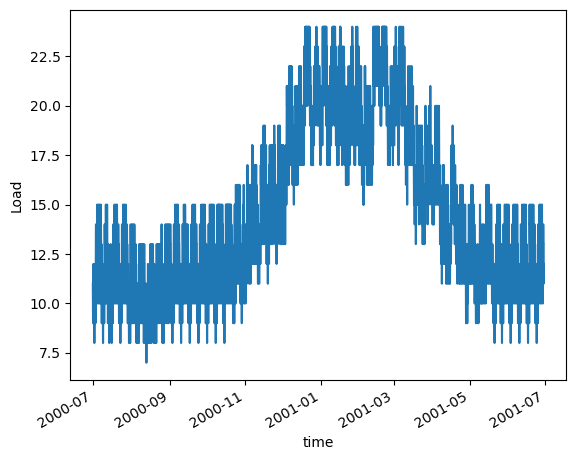

In [212]:
energy_scenario.Load.plot()

# Calculs macro

#### Couts

In [48]:
#Unité chelou par rapport à l'excel (x10 pour le charging et l'énergy)
def compute_cost(context,capacity_data,cost_data) :
    #Charging Data 
    unserved_energy_cost=cost_data['unserved_energy_cost']
    diesel_variable_cost=cost_data['diesel_variable_cost']
    solar_cost=cost_data['solar_cost']
    wind_cost=cost_data['wind_cost']
    diesel_cost=cost_data['diesel_cost']
    storage_power_cost=cost_data['storage_power_cost']
    storage_energy_cost=cost_data['storage_energy_cost']
    solar_om_cost=cost_data['solar_om_cost']
    wind_om_cost=cost_data['wind_om_cost']
    diesel_om_cost=cost_data['diesel_om_cost']
    nvp = cost_data['nvp']
    energy_scenario = compute_data(context,capacity_data)
    total_cost_prod = solar_cost*solar_gen + wind_cost*wind_gen + diesel_cost*np.max([diesel_gen-diesel_param,0])+storage_power_cost*charging_power +storage_energy_cost*Energy 
    total_cost_om = solar_om_cost*solar_gen + wind_om_cost*wind_gen +diesel_om_cost*diesel_gen
    total_fuel_cost = np.sum(energy_scenario.diesel.values)*diesel_variable_cost
    total_lole_cost = unserved_energy_cost*np.sum(energy_scenario.unserved_energy.values)

    total_cost_2021 =total_cost_prod+ (total_cost_om + total_fuel_cost + total_lole_cost)*nvp 
    final_cost_dic = {'total_cost_2021':total_cost_2021*1e-6,'total_cost_prod':total_cost_prod*1e-6,'total_cost_om_2021':total_cost_om*nvp*1e-6,'total_fuel_cost_2021':total_fuel_cost*nvp*1e-6,'total_lole_cost_2021':total_lole_cost*nvp*1e-6}
#     final_cost =pd.DataFrame([0,1,2,3],final_cost_dic)
    return(final_cost_dic)
compute_cost(context,capacity_data,cost_data)

{'total_cost_2021': 122.112703,
 'total_cost_prod': 48.0,
 'total_cost_om_2021': 24.919999999999998,
 'total_fuel_cost_2021': 43.436183,
 'total_lole_cost_2021': 5.756520000000003}

#### Calcul des émissions de CO2

In [135]:
emission_diesel = np.sum(diesel.values)*diesel_co2
emission_diesel

69721.0